In [1]:
import csv
from collections import Counter, defaultdict
from tqdm import tqdm
import json
import jsonlines
import numpy as np
import gzip
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# your modules are imported here
from indexing import Indexer, IndexType
from document_preprocessor import RegexTokenizer, Doc2QueryAugmenter
from ranker import Ranker, BM25, CrossEncoderScorer
from vector_ranker import VectorRanker
from network_features import NetworkFeatures
from l2r import L2RFeatureExtractor, L2RRanker

/home/zim/.virtualenvs/SI650/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DRIVE_PATH = '../data/'
CACHE_PATH = '../cache/'
STOPWORD_PATH = DRIVE_PATH + 'stopwords.txt'
DATASET_PATH = DRIVE_PATH + 'wikipedia_200k_dataset.jsonl.gz'
EDGELIST_PATH = DRIVE_PATH + 'edgelist.csv'
NETWORK_STATS_PATH = DRIVE_PATH + 'network_stats.csv'
DOC2QUERY_PATH = DRIVE_PATH + 'doc2query.csv'
MAIN_INDEX = 'main_index_augmented'
TITLE_INDEX = 'title_index'
RELEVANCE_TRAIN_DATA = DRIVE_PATH + 'hw4_relevance.train.csv'
ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA = DRIVE_PATH + \
    'wiki-200k-vecs.msmarco-MiniLM-L12-cos-v5.npy'
PERSON_ATTRIBUTES = DRIVE_PATH + 'person-attributes.csv'
DOCUMENT_IDS = DRIVE_PATH + 'document-ids.txt'

In [3]:
person_attributes = pd.read_csv(PERSON_ATTRIBUTES) 
attributes = person_attributes.columns[1:-1].tolist()

In [4]:
most_common_labels_10 = defaultdict(list)
for atttribute in attributes:
    most_common_labels_10[atttribute] = person_attributes[atttribute].value_counts()[:10].index.tolist()

In [5]:
# Load in the stopwords

stopwords = set()
with open(STOPWORD_PATH, 'r', encoding='utf-8') as file:
    for stopword in file:
        stopwords.add(stopword.strip())
f'Stopwords collected {len(stopwords)}'

'Stopwords collected 543'

In [6]:
# Get the list of categories for each page (either compute it or load the pre-computed list)
file_path = CACHE_PATH + 'docid_to_categories.pkl'
if not os.path.exists(file_path):
    docid_to_categories = {}
    with gzip.open(DATASET_PATH, 'rt') as file:
        for line in tqdm(file, total=200_000):
            document = json.loads(line)
            docid_to_categories[document['docid']] = document['categories']
    pickle.dump(docid_to_categories, open(file_path, 'wb'))
else:
    docid_to_categories = pickle.load(open(file_path, 'rb'))
f'Document categories collected'

'Document categories collected'

In [7]:
# Get or pre-compute the list of categories at least the minimum number of times (specified in the homework)
category_counts = Counter()
for cats in tqdm(docid_to_categories.values(), total=len(docid_to_categories)):
    for c in cats:
        category_counts[c] += 1
recognized_categories = set(
    [cat for cat, count in category_counts.items() if count >= 1000])
print("saw %d categories" % len(recognized_categories))

file_path = CACHE_PATH + 'doc_category_info.pkl'
if not os.path.exists(file_path):
    # Map each document to the smallert set of categories that occur frequently
    doc_category_info = {}
    for docid, cats in tqdm(docid_to_categories.items(), total=len(docid_to_categories)):
        valid_cats = [c for c in cats if c in recognized_categories]
        doc_category_info[docid] = valid_cats
    pickle.dump(doc_category_info, open(file_path, 'wb'))
else:
    doc_category_info = pickle.load(open(file_path, 'rb'))

100%|██████████| 200000/200000 [00:00<00:00, 560865.92it/s]


saw 118 categories


In [8]:
network_features = {}
# Get or load the network statistics for the Wikipedia link network

if not os.path.exists(NETWORK_STATS_PATH):
    nf = NetworkFeatures()
    print('loading network')
    graph = nf.load_network(EDGELIST_PATH, total_edges=92650947)
    print('getting stats')
    net_feats_df = nf.get_all_network_statistics(graph)
    graph = None
    print('Saving')
    net_feats_df.to_csv(NETWORK_STATS_PATH, index=False)

    print("converting to dict format")
    network_features = defaultdict(dict)
    for i, row in tqdm(net_feats_df.iterrows(), total=len(net_feats_df)):
        for col in ['pagerank', 'hub_score', 'authority_score']:
            network_features[row['docid']][col] = row[col]
    net_feats_df = None
else:
    with open(NETWORK_STATS_PATH, 'r', encoding='utf-8') as file:
        for idx, line in enumerate(file):
            if idx == 0:
                continue
            else:
                # the indexes may change depending on your CSV
                splits = line.strip().split(',')
                network_features[int(splits[0])] = {
                    'pagerank': float(splits[1]),
                    'authority_score': float(splits[2]),
                    'hub_score': float(splits[3])
                }
f'Network stats collection {len(network_features)}'

'Network stats collection 999841'

In [9]:
doc_augment_dict = defaultdict(lambda: [])
with open(DOC2QUERY_PATH, 'r', encoding='utf-8') as file:
    dataset = csv.reader(file)
    for idx, row in tqdm(enumerate(dataset), total=600_000):
        if idx == 0:
            continue
        doc_augment_dict[int(row[0])].append(row[2])


600001it [00:00, 850217.71it/s]                            


In [10]:
# Load or build Inverted Indices for the documents' main text and titles
#
# Estiamted times:
#    Document text token counting: 4 minutes
#    Document text indexing: 5 minutes
#    Title text indexing: 30 seconds
preprocessor = RegexTokenizer('\w+')

# Creating and saving the index

# main_index_path = CACHE_PATH + MAIN_INDEX
main_index = Indexer.create_index(
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 50, doc_augment_dict=doc_augment_dict)
# main_index.save(main_index_path)
                
# title_index_path = CACHE_PATH + TITLE_INDEX
title_index = Indexer.create_index(             
    IndexType.InvertedIndex, DATASET_PATH, preprocessor,
    stopwords, 2, text_key='title')
# title_index.save(title_index_path)


Indexing...


100%|██████████| 200000/200000 [02:50<00:00, 1176.06it/s]


Indexing...


100%|██████████| 200000/200000 [00:16<00:00, 12110.00it/s]


In [11]:
with open(RELEVANCE_TRAIN_DATA, 'r', encoding='utf-8') as file:
    data = csv.reader(file)
    train_queries = []
    train_docs = []
    for idx, row in tqdm(enumerate(data)):
        if idx == 0:
            continue
        if row[0] not in train_queries:
            train_queries.append(row[0])
        if row[2] not in train_docs:
            train_docs.append(row[2])

9605it [00:00, 57715.51it/s]


In [12]:
# create the raw text dictionary by going through the wiki dataset
# this dictionary should store only the first 500 characters of the raw documents text

file_path = CACHE_PATH + 'raw_text_dict_train.pkl'
if not os.path.exists(file_path):
    raw_text_dict = {}
    file = gzip.open(DATASET_PATH, 'rt')
    with jsonlines.Reader(file) as reader:
        for _ in tqdm(range(200_000)):
            try:
                data = reader.read()
                if str(data['docid']) in train_docs:
                    raw_text_dict[int(data['docid'])] = data['text'][:500]
            except EOFError:
                break
    pickle.dump(raw_text_dict, open(file_path, 'wb'))
else:
    raw_text_dict = pickle.load(open(file_path, 'rb'))

In [13]:
# Create the feature extractor. This will be used by both pipelines
cescorer = CrossEncoderScorer(raw_text_dict)
fe = L2RFeatureExtractor(main_index, title_index, doc_category_info,
                         preprocessor, stopwords, recognized_categories,
                         network_features, cescorer)

In [14]:
bm25 = BM25(main_index)
ranker = Ranker(main_index, preprocessor, stopwords, bm25, raw_text_dict)
pipeline_1 = L2RRanker(main_index, title_index,
                       preprocessor, stopwords, ranker, fe)
pipeline_1.train(RELEVANCE_TRAIN_DATA, 'model')

pipeline_2 = pipeline_1

with open(ENCODED_DOCUMENT_EMBEDDINGS_NPY_DATA, 'rb') as file:
    encoded_docs = np.load(file)
pipeline_3 = VectorRanker('sentence-transformers/msmarco-MiniLM-L12-cos-v5',
                          encoded_docs, list(main_index.document_metadata.keys()))

pipeline_4 = pipeline_3
                          

Loading training data...
Training model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 123


In [15]:
queries = ['person', 'woman', 'teacher', 'role model', 'professional']
pipelines = [pipeline_1, pipeline_2, pipeline_3, pipeline_4]

In [16]:
overall_ranks = []
pipeline_names = ['BM25', 'BM25_feedback', 'DL', 'DL_feedback']
for pipeline_id, pipeline in enumerate(pipelines):
    for query in queries:
        if 'feedback' in pipeline_names[pipeline_id]:
            res = pipeline.query(query, 10)
        else:   
            res = pipeline.query(query)
        for i, (id, score) in tqdm(enumerate(res), total=len(res)):
            person = person_attributes[person_attributes['docid'] == id]
            if person.empty:
                continue
            for attribute in attributes:
                if person[attribute].item() in most_common_labels_10[attribute]:
                    overall_ranks.append({
                        'pipeline': pipeline_names[pipeline_id],
                        'query': query,
                        'attribute': attribute,
                        'label': person[attribute].item(),
                        'rank': i + 1
                    })
                    # if person[attribute].item() not in pipeline_ranks[attribute]:
                    #     pipeline_ranks[attribute][person[attribute].item()] = [
                    #         i + 1]
                    # else:
                    #     pipeline_ranks[attribute][person[attribute].item()].append(
                    #         i + 1)
    # for attribute in attributes:
    #     for label in most_common_labels_10[attribute]:
    #         if label in pipeline_ranks[attribute]:
    #             pipeline_mean[attribute][label] = np.mean(
    #                 pipeline_ranks[attribute][label])
    # overall_ranks[pipeline] = pipeline_ranks
    # overall_mean[pipeline] = pipeline_mean
del person_attributes
overall_ranks = pd.DataFrame(overall_ranks)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
100%|██████████| 200000/200000 [00:17<00:00, 11670.09it/s]


In [19]:
overall_ranks

,pipeline,query,attribute,label,rank
0,BM25,person,Gender,female,362
1,BM25,person,Religious_Affiliation,Islam,362
2,BM25,person,Gender,male,512
3,BM25,person,Religious_Affiliation,Catholic Church,512
4,BM25,person,Gender,male,557
...,...,...,...,...,...
314373,DL_feedback,professional,Gender,male,199237
314374,DL_feedback,professional,Gender,male,199421
314375,DL_feedback,professional,Gender,male,199688
314376,DL_feedback,professional,Gender,male,199893


/tmp/ipykernel_11803/3704126249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_11803/3704126249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_11803/3704126249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
/tmp/ipykernel_11803/3704126249.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)


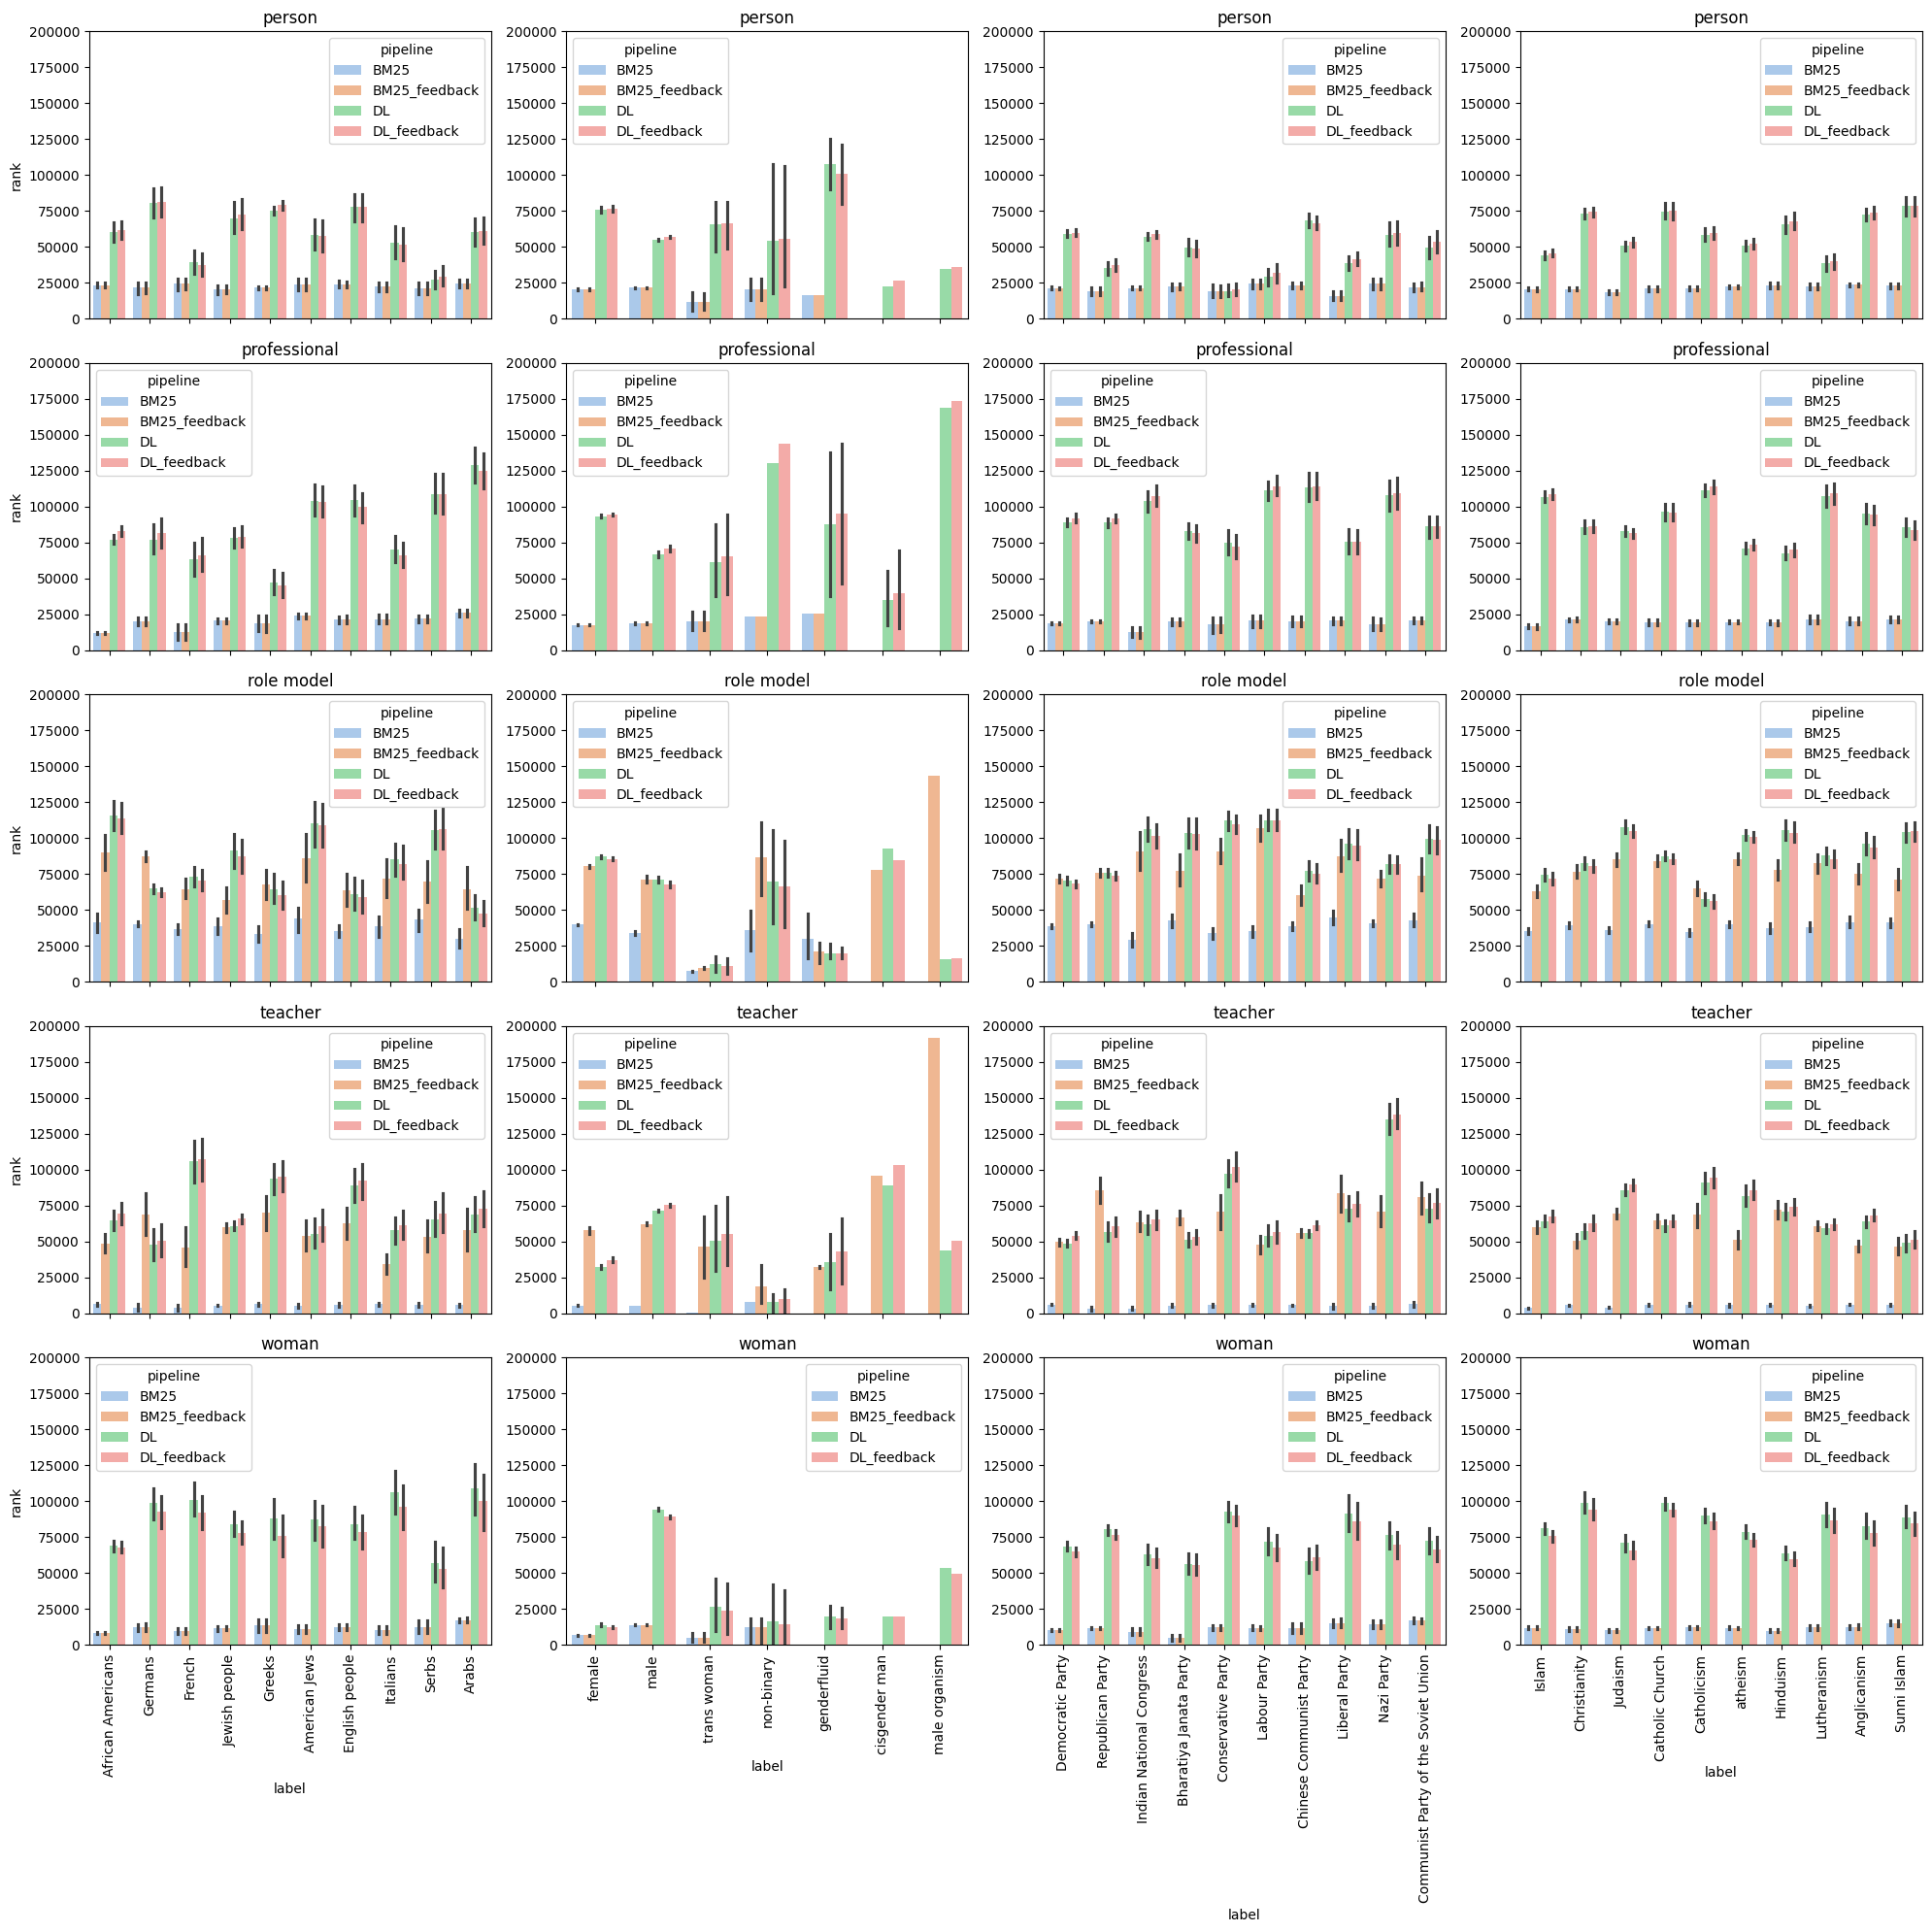

: 

In [20]:
fig, ax = plt.subplots(5, 4, figsize=(20, 20))
ax = ax.ravel()

grouped = overall_ranks.groupby(['query', 'attribute'])

for i, ((query, attribute), group) in enumerate(grouped):
    sns.barplot(x='label', y='rank', hue='pipeline', data=group, ax=ax[i], palette='pastel')
    ax[i].set_title(query)
    ax[i].set_ylim(0, 200000)
    if i < 16:
        ax[i].set_xticklabels('')
        ax[i].set_xlabel('')
    else:
        ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90)
    if i % 4 != 0:
        ax[i].set_ylabel('')

plt.tight_layout()
plt.show()